In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
logging.debug("test")

2024-02-01 16:13:19,697 - root - DEBUG - test


In [6]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load Data

In [7]:
# experiment specific
result_base_dir = "ss1FDR_BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_threshold_missabthres0.5_convergence_NoIntercept_pred"

In [8]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
MS1Scans_NoArray_path = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_MS1Scans_NoArray.csv"
)
result_dir = os.path.join(result_parent_dir, result_base_dir)
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)
output_file = os.path.join(result_dir, "output")  # filename
maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [9]:
# Load data
MS1Scans_NoArray = pd.read_csv(MS1Scans_NoArray_path)
MS1Scans_NoArray["scan_number"] = MS1Scans_NoArray.index.astype(int)
Maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
Maxquant_result_dict.index = Maxquant_result_dict["id"]
Maxquant_result_exp = pd.read_csv(filepath_or_buffer=maxquant_file_exp, sep="\t")
scan_record = pd.read_pickle(output_file + "_scan_record.pkl")
sum_raw = pd.read_csv(os.path.join(result_dir, "sum_raw.csv"))
sum_minima = pd.read_csv(os.path.join(result_dir, "sum_minima.csv"))
sum_gaussian = pd.read_csv(os.path.join(result_dir, "sum_gaussian.csv"))

# Extract Activation Peak

In [12]:
import numpy as np

refit_activation_minima = np.load(output_file + "_activationMinima.npy")

In [ ]:
%autoreload 2
from postprocessing import post_processing
sum_peak, peak_results = post_processing.select_peak_from_activation(
    maxquant_result_ref=Maxquant_result_dict,
    ms1scans_no_array=MS1Scans_NoArray,
    activation=refit_activation_minima,
    return_peak_result=True,  # default find peaks setting, minimal peak_width = 2
)
sum_peak.to_csv(os.path.join(result_dir, "sum_peak_updated.csv"), index=False)
peak_results.to_csv(
    os.path.join(result_dir, "peak_results_updated.csv"), index=False
)

# TODO: clean

In [6]:
# SBS windows
MS1Scans_NoArray = pd.read_csv(MS1Scans_NoArray_path)
MS1Scans_NoArray["scan_number"] = MS1Scans_NoArray.index.astype(int)
RT_ref = "predicted_RT"
RT_tol = 1
sbs_windows = Maxquant_result_dict[["id", RT_ref]]
sbs_windows["sbs_window_left"] = sbs_windows[RT_ref] - RT_tol
sbs_windows["sbs_window_right"] = sbs_windows[RT_ref] + RT_tol
sbs_windows.sort_values(by="sbs_window_left", inplace=True)
sbs_windows = pd.merge_asof(
    sbs_windows,
    MS1Scans_NoArray[["starttime", "scan_number"]],
    left_on="sbs_window_left",
    right_on="starttime",
    direction="nearest",
)
sbs_windows = pd.merge_asof(
    sbs_windows,
    MS1Scans_NoArray[["starttime", "scan_number"]],
    left_on="sbs_window_right",
    right_on="starttime",
    direction="nearest",
    suffixes=["_left", "_right"],
)
sbs_windows["starttime_length"] = (
    sbs_windows["starttime_right"] - sbs_windows["starttime_left"]
)
sbs_windows["scan_number_length"] = (
    sbs_windows["scan_number_right"] - sbs_windows["scan_number_left"]
)

/tmp/ipykernel_2722742/2406514058.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbs_windows["sbs_window_left"] = sbs_windows[RT_ref] - RT_tol
/tmp/ipykernel_2722742/2406514058.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbs_windows["sbs_window_right"] = sbs_windows[RT_ref] + RT_tol
/tmp/ipykernel_2722742/2406514058.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [7]:
sbs_windows["scan_number_length"].describe()
sbs_windows["starttime_length"].describe()
peak_results = pd.merge(left=peak_results, right=sbs_windows, on="id", how="left")

count    63013.000000
mean       119.168251
std         19.503501
min        116.000000
25%        116.000000
50%        117.000000
75%        117.000000
max        390.000000
Name: scan_number_length, dtype: float64

count    63013.000000
mean         1.999964
std          0.008106
min          1.736767
25%          1.991852
50%          2.003904
75%          2.006835
max          2.016720
Name: starttime_length, dtype: float64

# Exploring finding peaks algo

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks

x = electrocardiogram()[2000:4000]

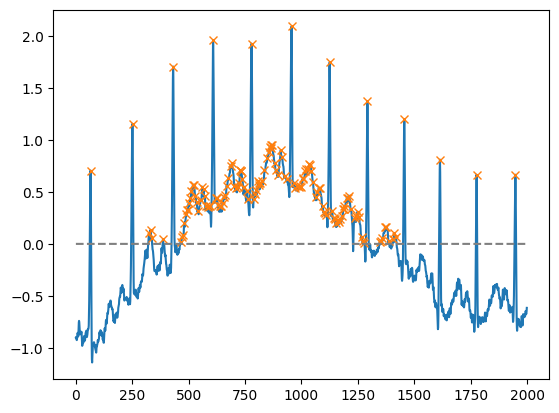

In [37]:
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

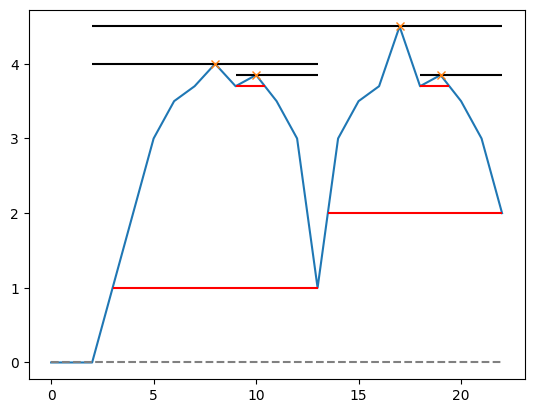

In [38]:
# Limit distance
x = np.array(
    [
        0,
        0,
        0,
        1,
        2,
        3,
        3.5,
        3.7,
        4,
        3.7,
        3.85,
        3.5,
        3,
        1,
        3,
        3.5,
        3.7,
        4.5,
        3.7,
        3.85,
        3.5,
        3,
        2,
    ]
)
peaks, properties = find_peaks(x, prominence=0, width=0, height=0, rel_height=1)
plt.plot(x)
for idx, peak in enumerate(peaks):
    # print(idx, peak)
    plt.hlines(
        xmin=properties["left_ips"][idx],
        xmax=properties["right_ips"][idx],
        y=properties["width_heights"][idx],
        color="red",
    )
    plt.hlines(
        xmin=properties["left_bases"][idx],
        xmax=properties["right_bases"][idx],
        y=properties["peak_heights"][idx],
        color="black",
    )
    # plt.hlines(
    #     xmin=peak - 0.5 * properties["widths"][idx],
    #     xmax=peak + 0.5 * properties["widths"][idx],
    #     y=properties["peak_heights"][idx],
    #     color="green",
    # )
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [39]:
properties

{'peak_heights': array([4.  , 3.85, 4.5 , 3.85]),
 'prominences': array([3.  , 0.15, 2.5 , 0.15]),
 'left_bases': array([ 2,  9,  2, 18]),
 'right_bases': array([13, 13, 22, 22]),
 'widths': array([10.        ,  1.42857143,  8.5       ,  1.42857143]),
 'width_heights': array([1. , 3.7, 2. , 3.7]),
 'left_ips': array([ 3. ,  9. , 13.5, 18. ]),
 'right_ips': array([13.        , 10.42857143, 22.        , 19.42857143])}

# Peak extraction with different width

Number of precursors: 55753
Label distribution:
False    208013
True      55753
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  2.637660e+05        2.637660e+05  2.637660e+05  263766.000000  263766.000000  263766.000000
mean   100514.209747    1129.355470      14.737834    1127.000057      14.699651    1132.004455      14.780400       5.004398  3.133223e+07        2.018463e+06  4.677740e-01       0.566401       0.558739       1.125140
std     58028.936860     530.692603       8.916898     530.754764       8.914841     530.598154       8.919384       5.981154  1.427096e+08        1.025395e+07  3.053284e-01       0.711914       0.715395       1.406701
min         0.000000      

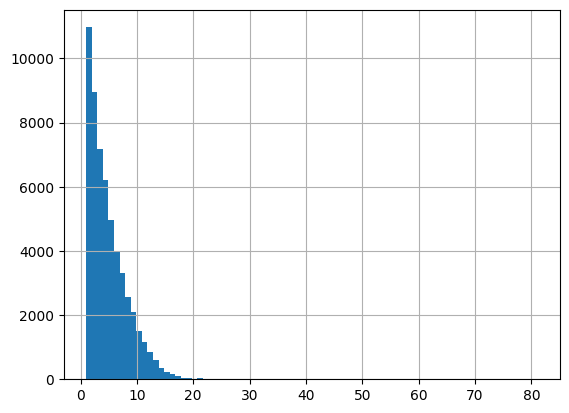

In [45]:
# Width = 1
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width1_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

Number of precursors: 55753
Label distribution:
False    202908
True      55753
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  2.586610e+05        2.586610e+05  2.586610e+05  258661.000000  258661.000000  258661.000000
mean   100500.713942    1133.850623      14.807237    1131.461778      14.768472    1136.540514      14.850498       5.078736  3.180421e+07        2.053892e+06  4.675197e-01       0.566178       0.559251       1.125429
std     58042.986541     528.198222       8.886482     528.276702       8.884657     528.084525       8.888722       6.015908  1.440531e+08        1.035122e+07  3.055485e-01       0.712962       0.716464       1.409157
min         0.000000      

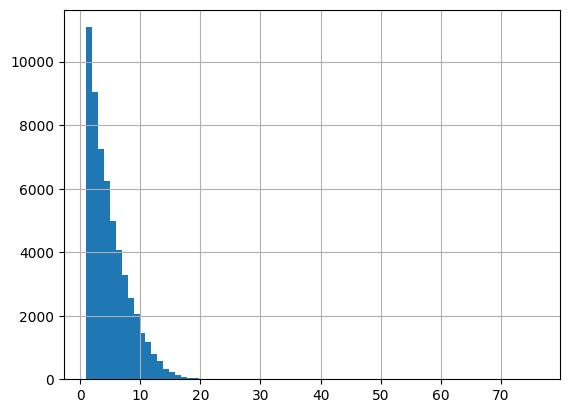

In [46]:
# Width = 2
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width2_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

Number of precursors: 51695
Label distribution:
False    108483
True      51695
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  1.601780e+05        1.601780e+05  1.601780e+05  160178.000000  160178.000000  160178.000000
mean   100302.708506    1142.212345      14.944811    1138.975365      14.892283    1145.935878      15.004608       6.960513  4.785421e+07        3.240916e+06  4.487215e-01       0.540794       0.536162       1.076956
std     58034.473869     527.948288       8.896179     528.104628       8.894360     527.722967       8.898489       7.009378  1.797651e+08        1.300499e+07  3.143144e-01       0.714881       0.718058       1.415272
min         0.000000      

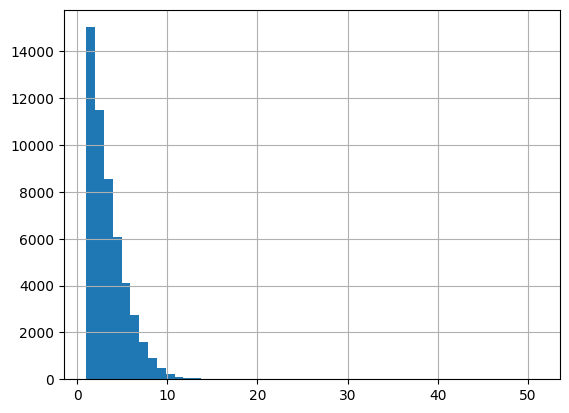

In [66]:
# Width = 3
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width3_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

3.971890897899969

array([[<Axes: title={'center': 'RT_diff_sum'}>]], dtype=object)

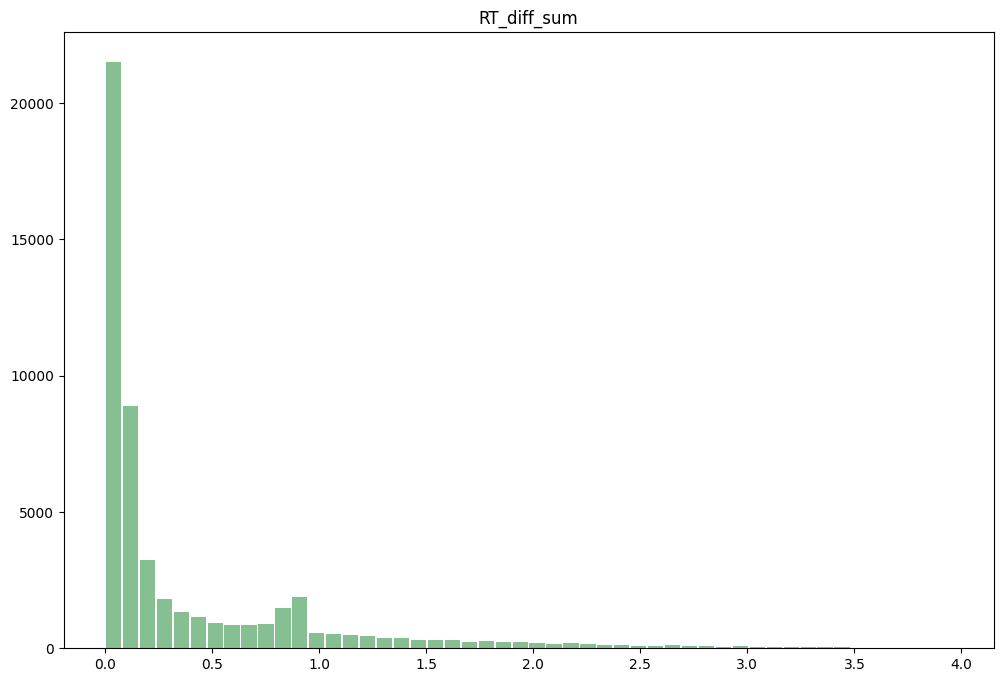

In [61]:
peak_results["RT_diff_sum"].quantile(0.99)
peak_results.loc[
    (peak_results.matched == 1) & (peak_results["RT_diff_sum"] <= 3.97)
].hist(
    column="RT_diff_sum",
    bins=50,
    grid=False,
    figsize=(12, 8),
    color="#86bf91",
    zorder=2,
    rwidth=0.9,
)

Number of precursors: 49362
Label distribution:
False    78326
True     49362
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  1.276880e+05        1.276880e+05  1.276880e+05  127688.000000  127688.000000  127688.000000
mean   100288.001418    1149.007025      15.051743    1145.332960      14.992082    1153.290442      15.120507       7.957482  5.778511e+07        3.993390e+06  4.340126e-01       0.523953       0.519493       1.043446
std     58051.711698     519.486899       8.766350     519.710087       8.764903     519.165352       8.768269       7.531420  1.994352e+08        1.446028e+07  3.169667e-01       0.709495       0.712316       1.405587
min         0.000000      37

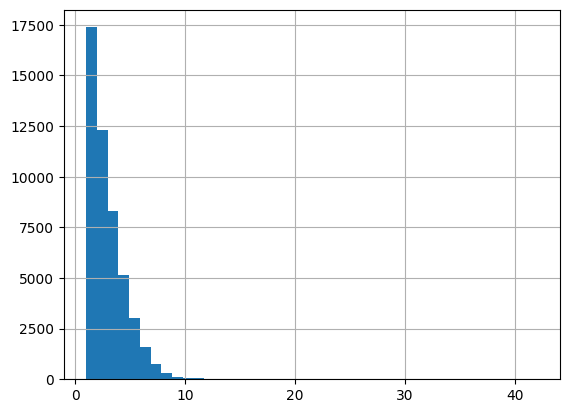

In [48]:
# Width = 4
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width4_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()